In [35]:
import numpy as np
import pandas as pd

In [1]:
import os
import matplotlib.pyplot as plt
from datetime import date,datetime
import logging

import torch
from torch import nn
from torchvision import datasets, transforms
from torch import optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 定义网络

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchN1 = nn.BatchNorm2d(64)
        self.LeakyReLU1 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchN2 = nn.BatchNorm2d(64*2)
        self.LeakyReLU2 = nn.LeakyReLU(0.2, inplace=True)       

        self.conv3 = nn.Conv2d(in_channels=64*2, out_channels=64*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchN3 = nn.BatchNorm2d(64*4)
        self.LeakyReLU3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv4 = nn.Conv2d(in_channels=64*4, out_channels=64*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchN4 = nn.BatchNorm2d(64*8)
        self.LeakyReLU4 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv5 = nn.Conv2d(in_channels=64*8, out_channels=1, kernel_size=4, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.LeakyReLU1(self.batchN1(self.conv1(x)))
        x = self.LeakyReLU2(self.batchN2(self.conv2(x)))
        x = self.LeakyReLU3(self.batchN3(self.conv3(x)))
        x = self.LeakyReLU4(self.batchN4(self.conv4(x)))
        x = self.conv5(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.ConvT1 = nn.ConvTranspose2d(in_channels=100, out_channels=64*8, kernel_size=4, bias=False) # 这里的in_channels是和初始的随机数有关
        self.batchN1 = nn.BatchNorm2d(64*8)
        self.relu1 = nn.ReLU()
        
        self.ConvT2 = nn.ConvTranspose2d(in_channels=64*8, out_channels=64*4, kernel_size=4, stride=2, padding=1, bias=False) # 这里的in_channels是和初始的随机数有关
        self.batchN2 = nn.BatchNorm2d(64*4)
        self.relu2 = nn.ReLU()        
        
        self.ConvT3= nn.ConvTranspose2d(in_channels=64*4, out_channels=64*2, kernel_size=4, stride=2, padding=1, bias=False) # 这里的in_channels是和初始的随机数有关
        self.batchN3 = nn.BatchNorm2d(64*2)
        self.relu3 = nn.ReLU()

        self.ConvT4 = nn.ConvTranspose2d(in_channels=64*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False) # 这里的in_channels是和初始的随机数有关
        self.batchN4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        
        self.ConvT5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh() # 激活函数
        
    def forward(self, x):
        x = self.relu1(self.batchN1(self.ConvT1(x)))
        x = self.relu2(self.batchN2(self.ConvT2(x)))
        x = self.relu3(self.batchN3(self.ConvT3(x)))
        x = self.relu4(self.batchN4(self.ConvT4(x)))
        x = self.ConvT5(x)
        x = self.tanh(x)
        return x

## 定义辅助函数

In [4]:
# 图像像素还原
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

## 加载数据集

In [5]:
trans = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = datasets.ImageFolder('./data', transform=trans) # 数据路径
dataloader = torch.utils.data.DataLoader(dataset,
                                    batch_size=128, # 批量大小
                                    shuffle=True, # 乱序
                                    num_workers=2 # 多进程
                                    )

## 网络的初始化

In [6]:
# ----------
# 初始化网络
# ----------
D = Discriminator().to(device) # 定义分类器
G = Generator().to(device) # 定义生成器
# -----------------------
# 定义损失函数和优化器
# -----------------------
learning_rate = 0.0002
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

## 完整走一遍训练流程

- 训练D(这个是有3个loss需要计算)
    - 计算d_loss_real
    - 计算d_loss_fake
    - 计算d_loss_penalty
        - 生成penalty region
- 训练G

### 训练D

In [7]:
batch_size = 36

In [8]:
# 创造real label和fake label
real_labels = torch.ones(batch_size, 1).to(device) # real的pic的label都是1
fake_labels = torch.zeros(batch_size, 1).to(device) # fake的pic的label都是0
noise = Variable(torch.randn(batch_size, 100, 1, 1)).to(device) # 随机噪声，生成器输入

In [9]:
# 真实的图片
images = torch.stack(([dataset[i][0] for i in range(batch_size)]))

In [17]:
# 一个batch36张, 每一张图片是3*64*64
images.shape

torch.Size([36, 3, 64, 64])

In [10]:
# 首先计算真实的图片的loss, d_loss_real
outputs = D(images)
d_loss_real = -torch.mean(outputs)

In [11]:
# 接着计算假的图片的loss, d_loss_fake
fake_images = G(noise)
outputs = D(fake_images)
d_loss_fake = torch.mean(outputs)

In [12]:
# 接着计算penalty region 的loss, d_loss_penalty

# 生成penalty region
alpha = torch.rand((batch_size, 1, 1, 1)).to(device)
x_hat = alpha * images.data + (1 - alpha) * fake_images.data
x_hat.requires_grad = True

In [13]:
# 计算penalty region处的梯度
pred_hat = D(x_hat)

In [14]:
gradient = torch.autograd.grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).to(device),
                   create_graph=False, retain_graph=False)

In [15]:
# 计算出每一张图, 每一个像素点处的梯度
gradient[0].shape

torch.Size([36, 3, 64, 64])

In [16]:
penalty_lambda = 10 # 梯度惩罚系数
gradient_penalty = penalty_lambda * ((gradient[0].view(gradient[0].size()[0], -1).norm(p=2,dim=1)-1)**2).mean()
gradient_penalty

tensor(0.0751)

In [238]:
# 三个loss相加, 反向传播进行优化
d_loss = d_loss_real + d_loss_fake + gradient_penalty
g_optimizer.zero_grad() # 两个优化器梯度都要清0
d_optimizer.zero_grad()
d_loss.backward()
d_optimizer.step()

### 训练G

## 使用保持的模型进行生成

- 使用随机数进行生成
- 使用又规律的数字进行生成

In [147]:
def show(img):
    """
    用来显示图片的
    """
    plt.figure(figsize=(24, 16))
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [18]:
G = Generator().to(device) # 定义生成器

In [20]:
# 读入生成器的模型
G.load_state_dict(torch.load('./models/G.ckpt', map_location='cpu'))

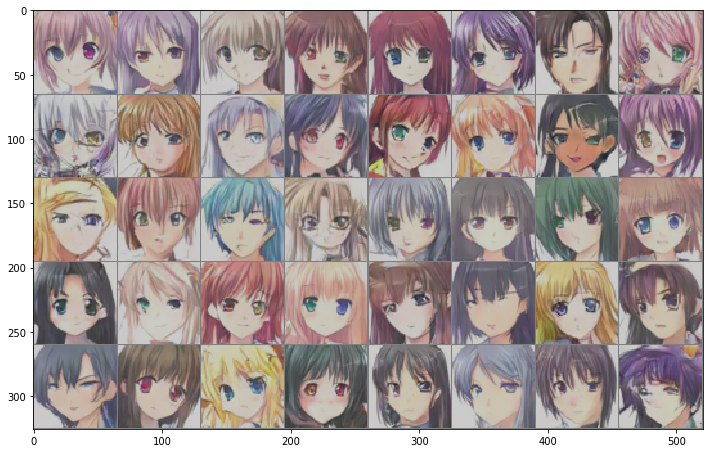

In [36]:
# 使用生成器来进行生成
test_noise = Variable(torch.FloatTensor(40, 100, 1, 1).normal_(0, 1)).to(device)
fake_image = G(test_noise)
show(make_grid(fake_image, nrow=8, padding=1, normalize=True, range=(-1, 1), scale_each=False, pad_value=0.5))

## 生成一个变换的过程

- 随机选两张图片, 作为对角线两端的图片
- 选两个特征,进行逐渐变换, 来生成递变的过程

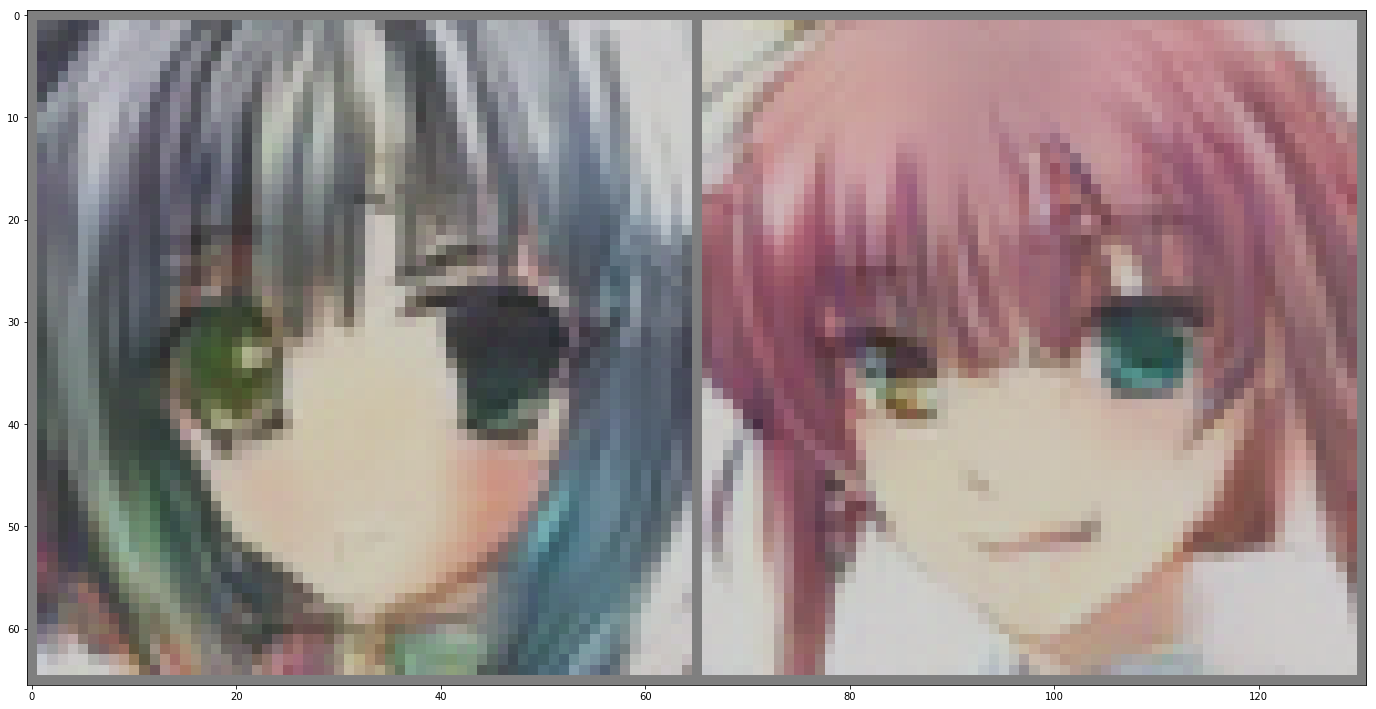

In [233]:
test_noise = Variable(torch.FloatTensor(2, 100, 1, 1).normal_(0, 1)).to(device)
fake_image = G(test_noise)
show(make_grid(fake_image, nrow=2, padding=1, normalize=True, range=(-1, 1), scale_each=False, pad_value=0.5))

In [234]:
leftTop = test_noise[0] # 左上角图片
rightBottom = test_noise[1] # 右下角图片

In [235]:
# 生成10*10的noise, 用来作为输入进行生成
interval = 10 # 图片的大小

rowAdd = [(leftTop[i]-rightBottom[i])/interval for i in range(0,50)] # 每一行每一格变化的长度
rowAddNums = [[leftTop[i] - rowAdd[i]*k for k in range(interval+1) ] for i in range(0,50)] # 变换后每一格的值
rowAddNums = np.transpose(np.array(rowAddNums))

columnAdd = [(leftTop[j]-rightBottom[j])/interval for j in range(50,100)] # 每一列每一格变化的长度
columnAddNums = [[leftTop[j] - columnAdd[j-50]*k for k in range(interval+1)] for j in range(50,100)] # 变换后每一格的值
columnAddNums = np.transpose(np.array(columnAddNums))

InterpolationNoise = leftTop.unsqueeze(0)

for columnAddNum in columnAddNums:
    for rowAddNum in rowAddNums:
        for i in range(0, 50):
            leftTop[i] = torch.tensor(rowAddNum[i])
        for j in range(50, 100):
            leftTop[j] = torch.tensor(columnAddNum[j-50])
        InterpolationNoise = torch.cat((InterpolationNoise, leftTop.unsqueeze(0)), dim=0)

In [184]:
InterpolationNoise.shape

torch.Size([122, 100, 1, 1])

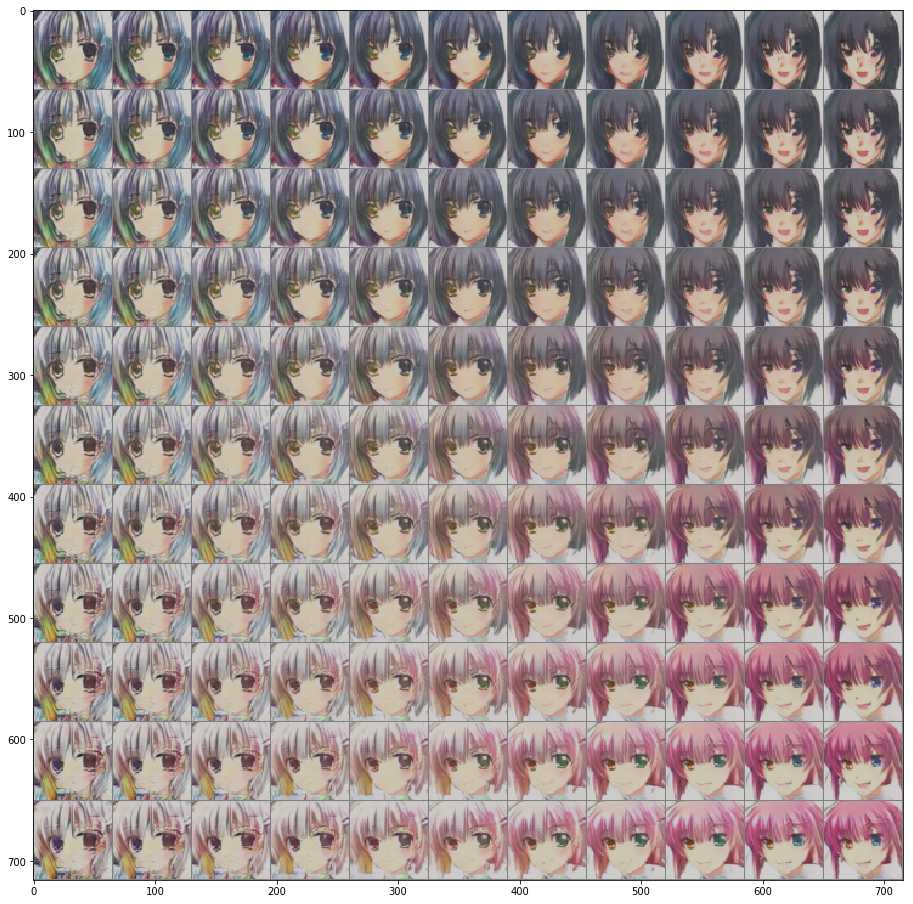

In [237]:
fake_image = G(InterpolationNoise[1:])
show(make_grid(fake_image, nrow=11, padding=1, normalize=True, range=(-1, 1), scale_each=False, pad_value=0.5))